In [310]:
from ETHAP.ml_logic.params import LOCAL_DATA_PATH, LOCAL_REGISTRY_PATH

import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load data

In [36]:
account_df = pd.read_csv(os.path.join(LOCAL_REGISTRY_PATH, "account.csv"))
account_df.drop("account", axis=1, inplace=True)
account_df.shape

(144499, 14)

In [37]:
account_df.head()

,n_sells,sell_volume,n_buys,buy_volume,nunique_collections,avg_time_trades,n_swaps,nunique_pools,avg_swap_volume,avg_time_swaps,n_sent,n_received,nunique_tokens,avg_time_transfers
0,0,0.00000,24,4.75450,2,3.493074e+04,5,2,6855.853922,2.611938e+06,22,256,23,107276.512635
1,0,0.00000,19,1.94528,10,5.859739e+05,21,6,5727.842921,2.192158e+06,120,256,132,151051.237333
2,0,0.00000,7,6.32000,2,3.779200e+04,7,4,20349.157010,3.804986e+06,222,256,69,124147.350105
3,0,0.00000,2,0.01400,1,5.600000e+02,22,15,1688.670090,2.195931e+06,256,256,86,115261.062622
4,1,-0.17778,2,0.60010,3,1.930938e+06,30,9,8951.421442,1.613565e+06,283,256,92,114120.511152


In [38]:
account_df.dtypes

n_sells                  int64
sell_volume            float64
n_buys                   int64
buy_volume             float64
nunique_collections      int64
avg_time_trades        float64
n_swaps                  int64
nunique_pools            int64
avg_swap_volume        float64
avg_time_swaps         float64
n_sent                   int64
n_received               int64
nunique_tokens           int64
avg_time_transfers     float64
dtype: object

# Correlation

<AxesSubplot: >

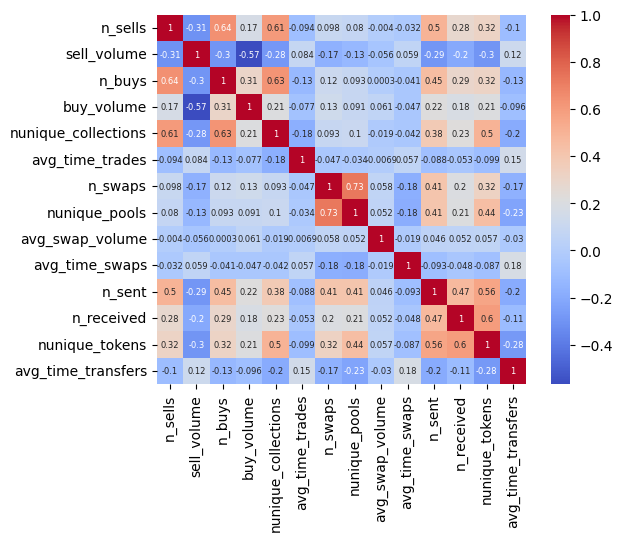

In [52]:
# Most of the features appear to be correlated 
# A dimensionality reduction technique is required before unsupervised clustering

corr_matrix = account_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, annot_kws={"size":6}, square=True)

# PCA

In [245]:
scaler = StandardScaler()
account_scaled = scaler.fit_transform(account_df)
pca = PCA()
pca.fit(account_scaled)

PCA()

In [178]:
# set dataframe background and font color
def background_color(v):
    if abs(v) <= 0.3:
        b_color = '#B1EDAB'
    elif abs(v) > 0.3 and abs(v) <= 0.5:
        b_color = "#82E279"
    elif abs(v) > 0.5 and abs(v) <= 0.7:
        b_color = "#25871D"
    else:
        b_color = "#0E320B"
    return 'background-color: %s' % b_color
def font_color(v):
    if abs(v) <= 0.3:
        f_color = "white"
    elif abs(v) > 0.3 and abs(v) <= 0.5:
        f_color = "black"
    elif abs(v) > 0.5 and abs(v) <= 0.7:
        f_color = "black"
    else:
        f_color = "white"
    return 'color: %s' % f_color

In [180]:
# Show all 14 principal components
W = pca.components_
W = pd.DataFrame(W.T,
                 index=account_df.columns,
                 columns=[f'PC{i}' for i in range(1, len(pca.explained_variance_ratio_)+1)])
cm = sns.light_palette("green", as_cmap=True)
W = W.style.background_gradient(cmap=cm).set_precision(3).applymap(background_color).applymap(font_color)
W

/tmp/ipykernel_13771/1335946467.py:6: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
n_sells,0.329,0.332,-0.209,0.001,-0.075,0.278,-0.121,0.005,0.252,0.270,-0.187,0.613,0.236,-0.196
sell_volume,-0.265,-0.135,-0.580,-0.051,0.137,0.071,-0.034,0.033,0.068,-0.601,0.294,0.300,0.001,-0.068
n_buys,0.337,0.337,-0.107,-0.044,-0.084,0.235,-0.129,-0.006,0.137,-0.452,-0.190,-0.591,0.182,-0.198
buy_volume,0.221,0.133,0.665,0.052,-0.133,-0.105,0.044,-0.002,0.040,-0.493,0.298,0.350,0.035,-0.011
nunique_collections,0.337,0.308,-0.195,-0.152,-0.011,0.109,-0.076,-0.138,-0.573,-0.048,0.071,0.090,-0.369,0.462
avg_time_trades,-0.101,-0.063,-0.019,0.571,-0.256,0.481,0.454,-0.386,-0.060,-0.035,-0.001,-0.010,-0.047,0.021
n_swaps,0.243,-0.500,0.035,0.056,-0.206,0.098,-0.352,-0.001,0.041,-0.105,-0.276,0.087,-0.574,-0.291
nunique_pools,0.251,-0.531,-0.035,0.040,-0.155,0.042,-0.256,-0.089,-0.149,-0.052,-0.037,0.015,0.613,0.389
avg_swap_volume,0.036,-0.088,0.246,0.128,0.830,0.436,-0.182,-0.033,-0.031,-0.001,-0.001,-0.001,-0.003,0.015
avg_time_swaps,-0.089,0.228,-0.080,0.479,0.106,-0.469,-0.460,-0.504,0.066,-0.022,-0.049,0.007,-0.002,0.009


In [246]:
# Explained variance and its cumulated sum

print("Number of PCs: ", len(pca.explained_variance_ratio_))

explained_v = pd.DataFrame({"explained_variance": pca.explained_variance_ratio_,
                            "cumulative_sum": pca.explained_variance_ratio_.cumsum()}, 
                           index=range(1,len(pca.explained_variance_ratio_)+1))
explained_v.index.name = "PCs"
explained_v.columns.name = "ev"
explained_v

Number of PCs:  14


ev,explained_variance,cumulative_sum
PCs,,
1,0.290846,0.290846
2,0.128443,0.419289
3,0.088279,0.507568
4,0.080980,0.588548
5,0.070739,0.659287
6,0.065731,0.725018
7,0.063065,0.788083
8,0.056750,0.844832
9,0.038934,0.883767


In [270]:
# Elbow Method to determine the number of components
# Base on compression(explained variance) and performance(cumulated share of explained variance)

fig = px.line(explained_v, 
              facet_col="ev", facet_col_wrap=2, 
              markers=True)

fig.add_hline(y=0.9, line_dash="dot", 
              row=1, col=2,
              annotation_text="cumulated share of explained variance = 0.9", 
              annotation_position="bottom right")

In [182]:
# According to inflection points above, components=8 looks promising

pca = PCA(n_components=8)
account_pca = pca.fit_transform(account_scaled)

# KMeans (determine number of k)

In [195]:
# Determine the number of clusters by searching the elbow of the sum of squared distances as K increases

Ks = range(10,50)
Sum_Dist = {"k": Ks, "SumDist_to_Centroid": []}

for k in Ks:
    model = KMeans(n_clusters=k)
    model.fit(account_pca)
    Sum_Dist["SumDist_to_Centroid"].append(model.inertia_)

In [269]:
# Plot to look for the inflection point 
# k=40 seems to be promising

px.line(Sum_Dist, x="k", y="SumDist_to_Centroid", 
        markers=True, width=700)

# KMeans (k=40)

In [271]:
model = KMeans(n_clusters=40)
model.fit(account_pca)

KMeans(n_clusters=40)

In [296]:
# Plot account labels

account_label = account_df.copy()
account_label["sell_volume"] = abs(account_label["sell_volume"])
account_label["label"] = model.labels_
account_label["label"] = account_label["label"].astype(str)
account_label.head()

,n_sells,sell_volume,n_buys,buy_volume,nunique_collections,avg_time_trades,n_swaps,nunique_pools,avg_swap_volume,avg_time_swaps,n_sent,n_received,nunique_tokens,avg_time_transfers,label
0,0,0.00000,24,4.75450,2,3.493074e+04,5,2,6855.853922,2.611938e+06,22,256,23,107276.512635,9
1,0,0.00000,19,1.94528,10,5.859739e+05,21,6,5727.842921,2.192158e+06,120,256,132,151051.237333,23
2,0,0.00000,7,6.32000,2,3.779200e+04,7,4,20349.157010,3.804986e+06,222,256,69,124147.350105,23
3,0,0.00000,2,0.01400,1,5.600000e+02,22,15,1688.670090,2.195931e+06,256,256,86,115261.062622,0
4,1,0.17778,2,0.60010,3,1.930938e+06,30,9,8951.421442,1.613565e+06,283,256,92,114120.511152,0


In [300]:
sample = account_label.sample(10000)

In [309]:
fig = px.scatter_3d(sample, 
                    x="n_swaps", y="buy_volume", z="avg_time_transfers", color="label", 
                    log_x=True, log_y=True, log_z=True, opacity=0.7)
fig.update_traces(marker=dict(size=5))
fig.show()